In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import numpy as np
import distributions 

from matplotlib import pyplot as plt
%matplotlib inline

EPS = 1e-8

Generator and discriminator parameter initializers

In [2]:
def make_gen(n_input = 100, n_hidden_1 = 300, n_hidden_2 = 300, n_out = 2,
             random_seed = None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    gen_params = {}
    gen_params['n_input'] = n_input
    gen_params['n_hidden_1'] = n_hidden_1 # 1st layer number of features
    gen_params['n_hidden_2'] = n_hidden_2 # 2nd layer number of features
    gen_params['n_out'] = n_out

    # Store layers weight & bias
    gen_params['weights'] = {
        'w1': tf.Variable(xavier_init([n_input, n_hidden_1]), name = 'g_w1'),
        'w2': tf.Variable(xavier_init([n_hidden_1, n_hidden_2]), name = 'g_w2'),
        'w_out': tf.Variable(xavier_init([n_hidden_2, n_out]), name = 'g_w_out')
    }
    gen_params['biases'] = {
        'b1': tf.Variable(tf.zeros([n_hidden_1]), name = 'g_b1'),
        'b2': tf.Variable(tf.zeros([n_hidden_2]), name = 'g_b1'),
        'b_out': tf.Variable(tf.zeros([n_out]), name = 'g_b_out')
    }
    
    #return parameter dict
    return(gen_params)

def make_disc(n_input = 2, n_hidden_1 = 300, n_hidden_2 = 300,
             random_seed = None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    disc_params = {}
    disc_params['n_input'] = n_input
    disc_params['n_hidden_1'] = n_hidden_1 # 1st layer number of features
    disc_params['n_hidden_2'] = n_hidden_2 # 2nd layer number of features

    # Store layers weight & bias
    disc_params['weights'] = {
        'w1': tf.Variable(xavier_init([n_input, n_hidden_1]), name = 'd_w1'),
        'w2': tf.Variable(xavier_init([n_hidden_1, n_hidden_2]), name = 'd_w2'),
        'w_out': tf.Variable(xavier_init([n_hidden_2, 1]), name = 'd_w_out')
    }
    disc_params['biases'] = {
        'b1': tf.Variable(tf.zeros([n_hidden_1]), name = 'd_b1'),
        'b2': tf.Variable(tf.zeros([n_hidden_2]), name = 'd_b1'),
        'b_out': tf.Variable(tf.zeros([1]), name = 'd_b_out')
    }
    
    #return parameter dict
    return(disc_params)

def make_Q(n_in, n_out,
          random_seed=None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    Q_params = {}
    Q_params['n_in'] = n_in
    Q_params['n_out'] = n_out 
    
    # Store layers weight & bias
    Q_params['weights'] = {
        'w': tf.Variable(xavier_init([n_in, n_out]), name = 'q_w'),
    }
    Q_params['biases'] = {
        'b': tf.Variable(tf.zeros([n_out]), name = 'q_b')
    }
    
    #return parameter dict
    return(Q_params)

GAN model

In [21]:
class GAN(object):
    def __init__(self, factor,
                 z_dim = 100, x_dim = 2, 
                 gen_hidden_1 = 300, gen_hidden_2 = 300,
                 disc_hidden_1 = 300, disc_hidden_2 = 300,
                 gen_params = None, disc_params = None,
                 random_seed = None):
        
        self.x_dim = x_dim
        self.factor = factor
        c_dim = factor.len
        self.c_dim = c_dim
        self.z_dim = z_dim
        
        #Generator params, may pass optional initialization
        gen_params = gen_params if gen_params is not None else make_gen(
            n_input = z_dim+c_dim, n_hidden_1 = gen_hidden_1, n_hidden_2 = gen_hidden_2, n_out = x_dim, 
            random_seed = random_seed
        )
        self.gen_params = gen_params
        
        g_theta = [theta for theta in gen_params['weights'].values()] + \
                  [theta for theta in gen_params['biases'].values()]
        self.g_theta = g_theta
            
        #Discriminator params, may pass optional initialization
        disc_params = disc_params if disc_params is not None else make_disc(
            n_input = x_dim, n_hidden_1 = disc_hidden_1, n_hidden_2 = disc_hidden_2,
            random_seed = random_seed
        )
        self.disc_params = disc_params
        
        d_theta = [theta for theta in disc_params['weights'].values()] + \
                  [theta for theta in disc_params['biases'].values()]
        self.d_theta = d_theta
        
        #Q params, may pass optional initialization
        q_params = make_Q(
            n_in = disc_hidden_2, n_out = c_dim,
            random_seed = random_seed
        )
        self.q_params = q_params
        
        q_theta = [theta for theta in q_params['weights'].values()] + \
                  [theta for theta in q_params['biases'].values()]
        self.q_theta = q_theta
            
        #GAN graph
        X = tf.placeholder(tf.float32, shape=[None, x_dim], name='X')
        self.X = X
        Z = tf.placeholder(tf.float32, shape=[None, z_dim], name='Z')
        self.Z = Z
        C = tf.placeholder(tf.float32, shape=[None, c_dim], name='C')
        self.C = C
        
        G_X = self.gen(Z, C)
        
        _, D_logit_real, D_real = self.disc(X)
        self.D_real = D_real
        
        _, D_logit_fake, D_fake = self.disc(G_X)
        self.D_fake = D_fake
        
        Q_logit = self.Q(G_X)
        self.Q_logit = Q_logit
        
    #Generator and discriminator models
    def gen(self, z, c):
        #Params
        weights = self.gen_params['weights']
        biases = self.gen_params['biases']
        
        zc = tf.concat((z,c), axis = 1)
        
        #Graph
        g_h1 = tf.nn.relu(tf.matmul(zc, weights['w1']) + biases['b1'])
        g_h2 = tf.nn.relu(tf.matmul(g_h1, weights['w2']) + biases['b2'])
        # Output layer with linear activation
        g_out = tf.matmul(g_h2, weights['w_out']) + biases['b_out']
        
        return(g_out)
    
    def disc(self, x):
        #Params
        weights = self.disc_params['weights']
        biases = self.disc_params['biases']
        
        #Graph
        d_h1 = tf.nn.relu(tf.matmul(x, weights['w1']) + biases['b1'])
        d_h2 = tf.nn.relu(tf.matmul(d_h1, weights['w2']) + biases['b2'])
        # Logit
        d_logit = tf.matmul(d_h2, weights['w_out']) + biases['b_out']
        #Probability
        d_prob = tf.nn.sigmoid(d_logit)
        
        return(d_h2, d_logit, d_prob)
    
    #Variational lower bound for mutual information
    def Q(self, x):
        #Params
        weights = self.q_params['weights']
        biases = self.q_params['biases']
        
        #Graph
        d_h2, _, _ = self.disc(x)
        Q_logit = tf.matmul(d_h2, weights['w']) + biases['b']
        return Q_logit
    
    def sample_C(self, m):
        return self.factor.sample(m).astype('float32')
    
    def sample_Z(self, m):
        return np.random.uniform(-1., 1., size=[m, self.z_dim]).astype('float32')
    
    def sample_G(self, m):
        return self.gen(self.sample_Z(m), self.sample_C(m))
    
    def train(self, x, lamb = .5, learning_rate = 0.001, training_epochs = 300, mb_size = 64, display_step = 30):
        sess = tf.Session()
        self.sess = sess
        
        N = len(x)
        n_batches = N // mb_size
        
        #Losses
        D_loss = -tf.reduce_mean(tf.log(self.D_real + EPS) + tf.log(1. - self.D_fake + EPS))
        G_loss = -tf.reduce_mean(tf.log(self.D_fake + EPS))
        Q_losses = []
        c_i = 0
        for dist in self.factor.dists:
            if isinstance(dist, distributions.Categorical):
                c_hat_logit = self.Q_logit[:,c_i:(c_i+dist.len)]
                c_hat = tf.nn.softmax(c_hat_logit)
                c = self.C[:,c_i:(c_i+dist.len)]
                Q_loss = tf.reduce_mean(-tf.reduce_sum(tf.multiply(tf.log(c_hat + EPS),c))) #Cross entropy
            else:
                c_hat = self.Q_logit[:,c_i:(c_i+dist.len)]
                c = self.C[:,c_i:(c_i+dist.len)]
                Q_loss = tf.reduce_mean(tf.square(c-c_hat)) #MSE
            Q_losses.append(Q_loss)
            c_i = c_i + dist.len - 1
        Q_loss = tf.reduce_mean(Q_losses) #MEAN CROSS ENTROPY OVER FACTORS
        G_Q_loss = G_loss + lamb*Q_loss
        
        #Optimizers
        D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(D_loss, var_list=self.d_theta)
#         G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(G_loss, var_list=self.g_theta)
#         Q_solver = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Q_loss, var_list=self.g_theta+self.q_theta)
        G_Q_solver = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(G_Q_loss, var_list=self.g_theta+self.q_theta)
        
        # Initializing the variables
        init = tf.global_variables_initializer()
        
        with sess.as_default():
            sess.run(init)
            neg_d_losses = []
            Q_losses = []
            for epoch in range(training_epochs):
                D_loss_avg = 0
                Q_loss_avg = 0
                if epoch % display_step == 0:
                    G_x = self.sample_G(1000).eval()
                    plt.figure()
                    plt.scatter(x[:,0], x[:,1])
                    plt.scatter(G_x[:,0], G_x[:,1])
                    plt.show()
                    if epoch > 1:
                        plt.figure()
                        plt.plot(neg_d_losses)
                        plt.title("Negative Discriminator Loss")
                        plt.xlabel("Epoch")
                        plt.ylabel("Negative D_Loss")

                        plt.figure()
                        plt.plot(Q_losses)
                        plt.title("Information LB")
                        plt.xlabel("Epoch")
                        plt.ylabel("Negative Q_Loss")
                    
                
                for batch in range(n_batches):
                    X_mb = x[(batch*mb_size):((batch+1)*mb_size), :]

                    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={self.X: X_mb, self.Z: self.sample_Z(mb_size), self.C: self.sample_C(mb_size)})
#                     _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={self.Z: self.sample_Z(mb_size), self.C: self.sample_C(mb_size)})
#                     _, Q_loss_curr = sess.run([Q_solver, Q_loss], feed_dict={self.Z: self.sample_Z(mb_size), self.C: self.sample_C(mb_size)})
                    _, G_loss_curr, Q_loss_curr = sess.run([G_Q_solver, G_loss, Q_loss], feed_dict={self.Z: self.sample_Z(mb_size), self.C: self.sample_C(mb_size)})
                    
                    D_loss_avg = D_loss_avg + D_loss_curr/n_batches
                    Q_loss_avg = Q_loss_avg + Q_loss_curr/n_batches
                neg_d_losses.append(-D_loss_avg)
                Q_losses.append(-Q_loss_avg)
            
            plt.figure()
            plt.plot(neg_d_losses)
            plt.title("Negative Discriminator Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Negative D_Loss")
            
            plt.figure()
            plt.plot(Q_losses)
            plt.title("Information LB")
            plt.xlabel("Epoch")
            plt.ylabel("Negative Q_Loss")

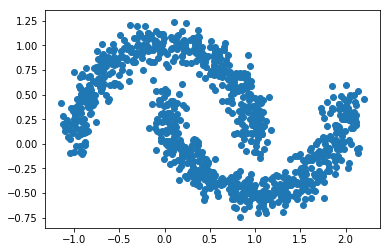

In [22]:
from sklearn.datasets import make_moons
N = 1000
X, Y = make_moons(N, noise = .1)
X = X.astype('float32')
Y = np.array([[1,0] if y else [0,1] for y in Y])

plt.scatter(X[:,0], X[:,1])

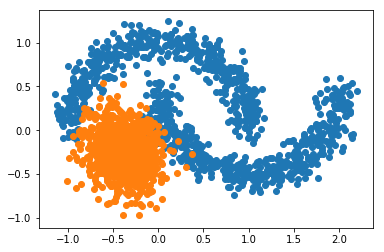

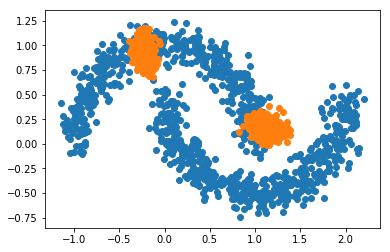

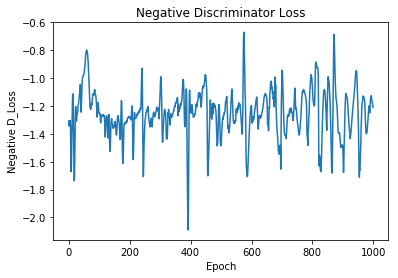

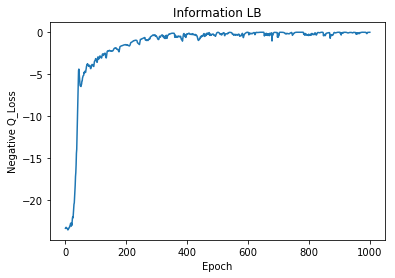

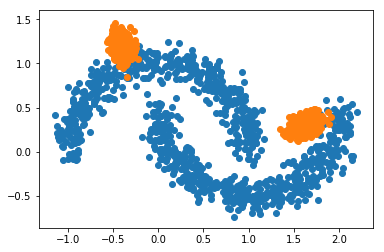

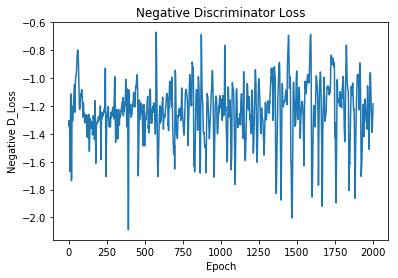

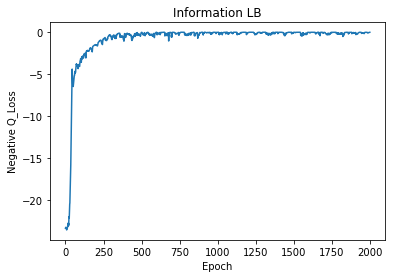

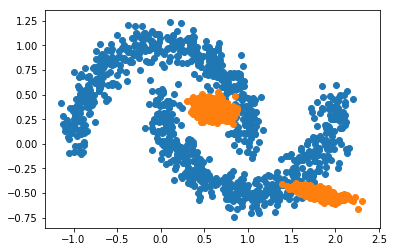

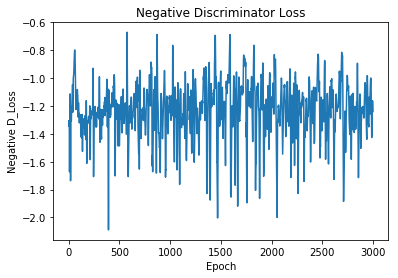

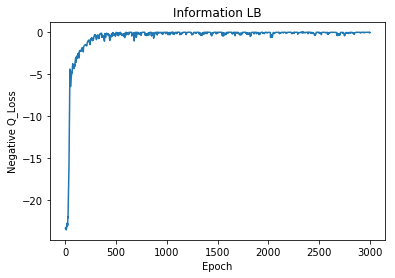

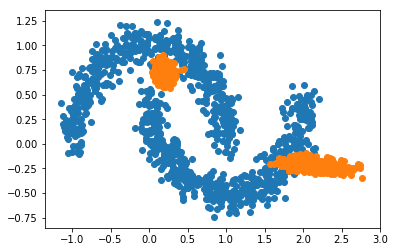

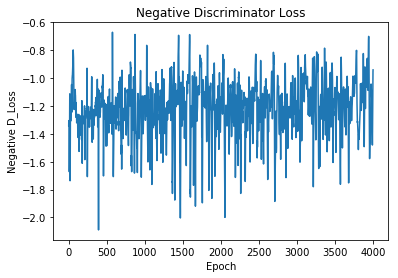

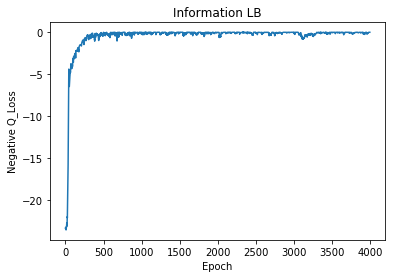

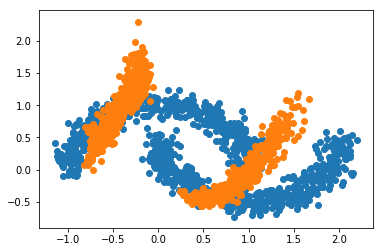

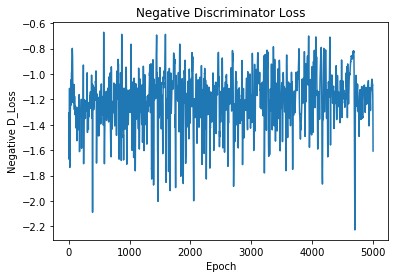

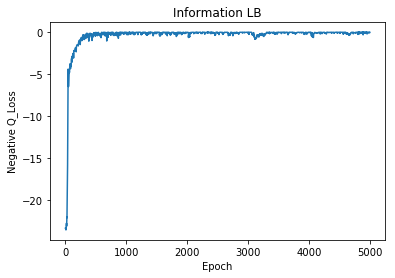

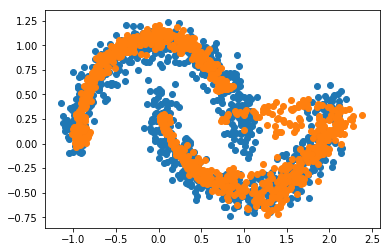

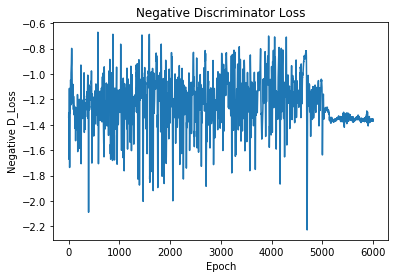

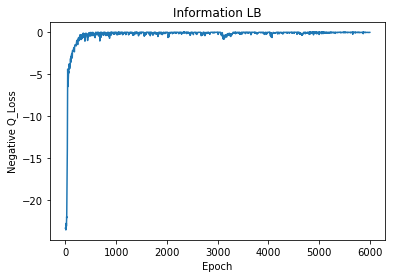

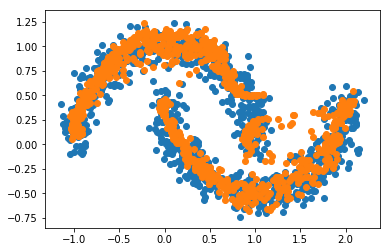

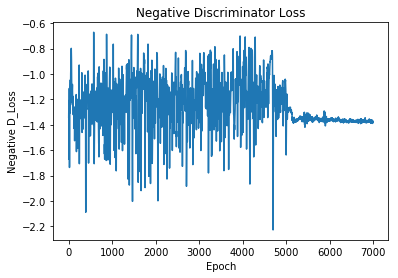

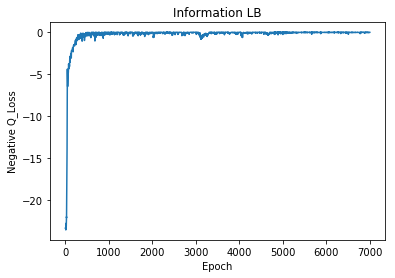

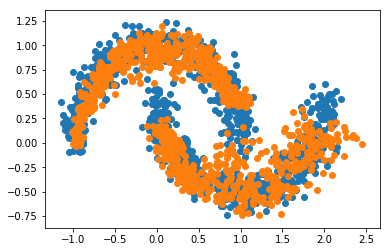

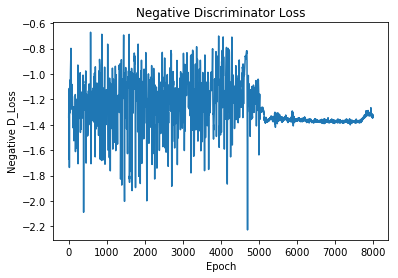

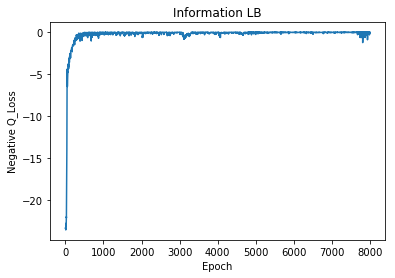

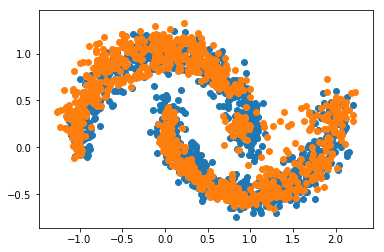

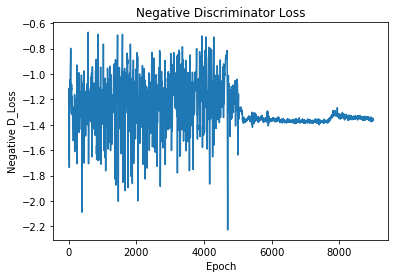

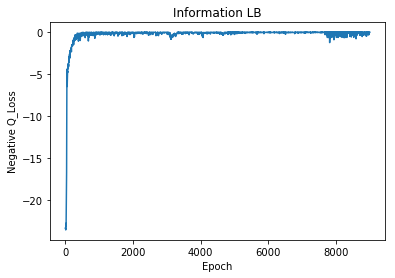

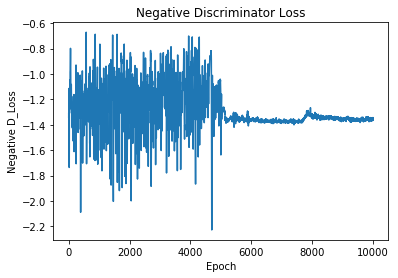

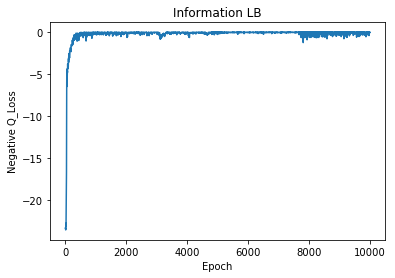

In [23]:
c = distributions.Categorical(2)
n = distributions.Normal()
f = distributions.Factor(c, *[n]*2)

gan = GAN(
    factor = f,
    z_dim = 100,
    x_dim = 2, 
    gen_hidden_1 = 300, gen_hidden_2 = 300,
    disc_hidden_1 = 300, disc_hidden_2 = 300,
)
gan.train(X, lamb = .2, learning_rate = 0.0001, training_epochs = 10000, mb_size = 100, display_step = 1000)

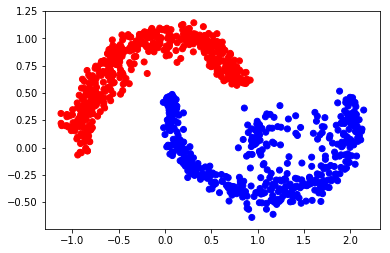

In [24]:
c = gan.sample_C(1000)
z = gan.sample_Z(1000)
g = gan.gen(z, c).eval(session=gan.sess)
plt.scatter(g[:,0], g[:,1], color = ['b' if np.argmax(ci[:2] == 0) else 'r' for ci in c])

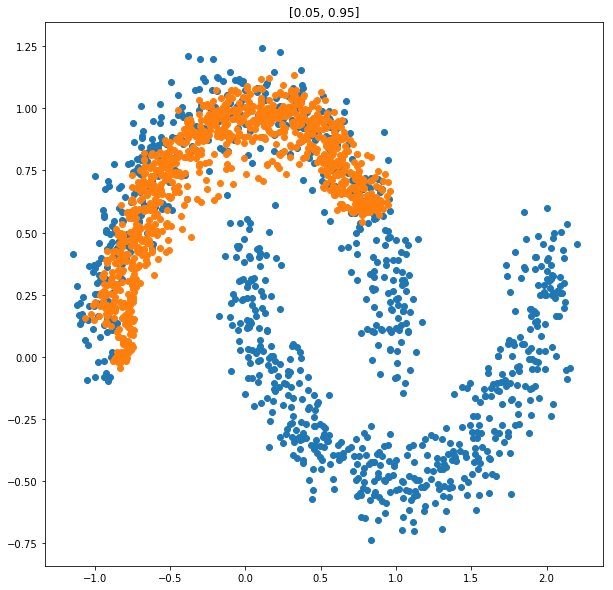

In [25]:
from matplotlib import animation, rc
rc('animation', html='html5')


fig, ax = plt.subplots(figsize=(10,10))
n = 1000

ax.scatter(X[:,0], X[:,1])
c = gan.sample_C(n)
z = gan.sample_Z(n)
c[:,:2] = [0,1]
g = gan.gen(z, c).eval(session=gan.sess)
sc = ax.scatter(g[:,0], g[:,1])

dt = .05
T = int(1/dt)

# animation function. This is called sequentially
def animate(i):
    if i > T: i = 2*T - i
    c[:,:2] = [0+i*dt,1-i*dt]
    g = gan.gen(z, c).eval(session=gan.sess)
    sc.set_offsets(g)
    ax.set_title("[%.2f, %.2f]" %(0+i*dt,1-i*dt))
    return (sc,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=2*T, interval=100, blit=True)


rc('animation', html='html5')

anim

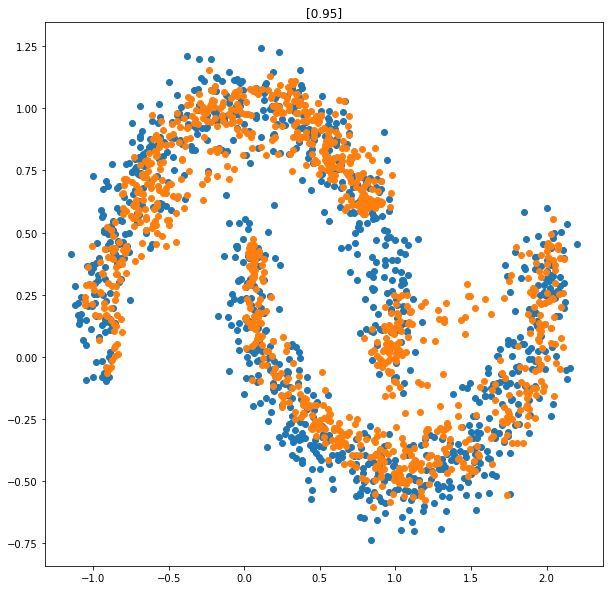

In [26]:
from matplotlib import animation, rc
rc('animation', html='html5')


fig, ax = plt.subplots(figsize=(10,10))
n = 1000

ax.scatter(X[:,0], X[:,1])
c = gan.sample_C(n)
z = gan.sample_Z(n)
c[:,2] = 1
g = gan.gen(z, c).eval(session=gan.sess)
sc = ax.scatter(g[:,0], g[:,1])

dt = .05
T = int(1/dt)

# animation function. This is called sequentially
def animate(i):
    t = i
    if i > 2*T: t = 4*T - i
    c[:,2] = 1-t*dt
    g = gan.gen(z, c).eval(session=gan.sess)
    sc.set_offsets(g)
    ax.set_title("[%.2f]" %(1-t*dt))
    return (sc,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=4*T, interval=100, blit=True)


rc('animation', html='html5')

anim

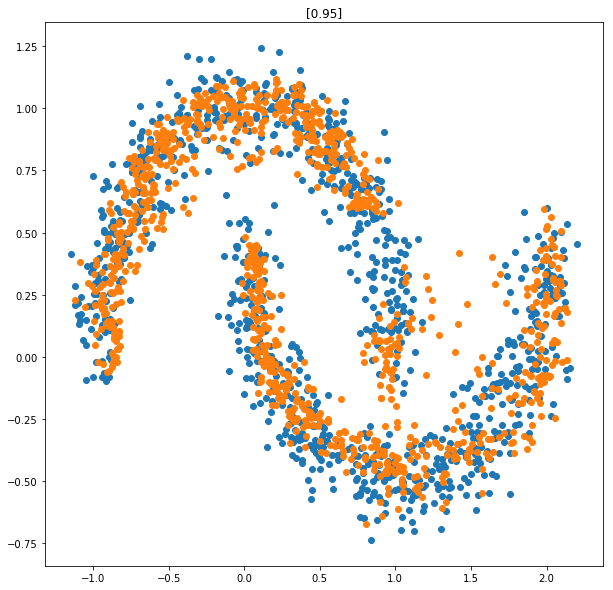

In [27]:
from matplotlib import animation, rc
rc('animation', html='html5')


fig, ax = plt.subplots(figsize=(10,10))
n = 1000

ax.scatter(X[:,0], X[:,1])
c = gan.sample_C(n)
z = gan.sample_Z(n)
c[:,3] = 1
g = gan.gen(z, c).eval(session=gan.sess)
sc = ax.scatter(g[:,0], g[:,1])

dt = .05
T = int(1/dt)

# animation function. This is called sequentially
def animate(i):
    t = i
    if i > 2*T: t = 4*T - i
    c[:,3] = 1-t*dt
    g = gan.gen(z, c).eval(session=gan.sess)
    sc.set_offsets(g)
    ax.set_title("[%.2f]" %(1-t*dt))
    return (sc,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=4*T, interval=100, blit=True)


rc('animation', html='html5')

anim

([array([ 408.,    0.,    3.,    0.,    0.,    0.,    0.,    1.,    0.,  588.]),
  array([ 588.,    0.,    1.,    0.,    0.,    0.,    0.,    3.,    0.,  408.])],
 array([  9.02634025e-20,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 2 Lists of Patches objects>)

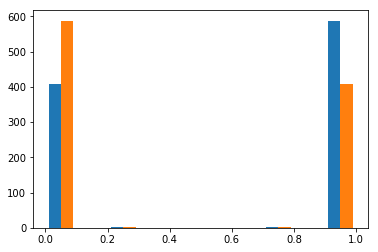

In [28]:
q = gan.Q(X).eval(session=gan.sess)
cont = q[:,2:]
cat = tf.nn.softmax(q[:,:2], 1).eval(session=gan.sess)
plt.hist(cat)

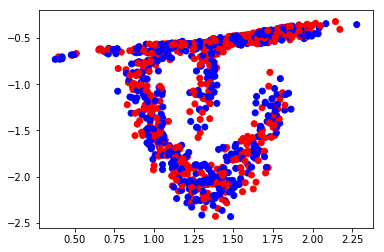

In [34]:
plt.scatter(cont[:,0], cont[:,1] , color = ['b' if np.argmax(ci[:2] == 0) else 'r' for ci in c])

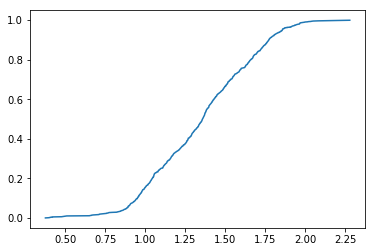

In [40]:
a = cont[:,0]
plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False))

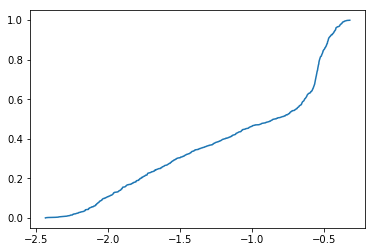

In [41]:
a = cont[:,1]
plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False))